In [9]:
from KalmanFilter import KalmanFilter
from SignalGenerator import SignalGenerator
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm  # For progress bar (optional)

# Create a synthetic signal
# Signal parameters
frequency = 480  # Hz
sampling_rate = 20000  # Hz
duration = 0.1  # seconds (100 ms)
amplitude = 0.1
offset = 0.1

SigGen = SignalGenerator(frequency, sampling_rate, duration, amplitude)

# Generate a clean 400 Hz sine wave
true_signal = SigGen.generate_signal('square')
true_signal = SigGen.add_offset(true_signal, offset)

# Add noise to create noisy measurement
noise_std = 0.3
noisy_signal = SigGen.add_noise(true_signal, noise_std)

# Get time vector
t= SigGen.get_time()

# Kalman Filter Matrices

## State Space Matrices
- F (State Transition Matrix): Describes how the state evolves from one time step to the next without external influences.
- H (Observation Matrix): Maps the state vector to the measurement space.

## Noise Covariance Matrices
- Q (Process Noise Covariance): Represents uncertainty in the state transition model.
- R (Measurement Noise Covariance): Represents uncertainty in the measurements.

## State Estimation Matrices
- P (State Covariance Matrix): Represents uncertainty in the current state estimate.
- x (State Vector): The actual state estimate the filter is computing.

MSE: 0.022511727043171212
RMSE: 0.15003908505176647


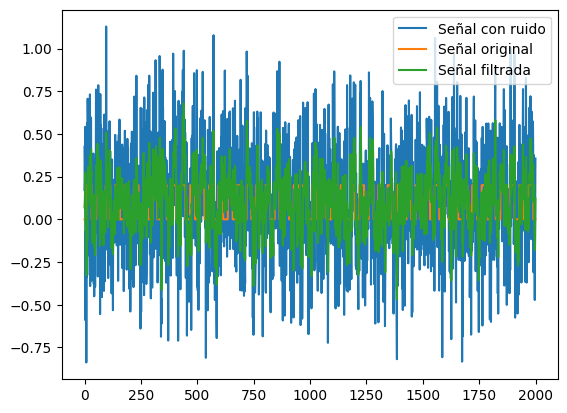

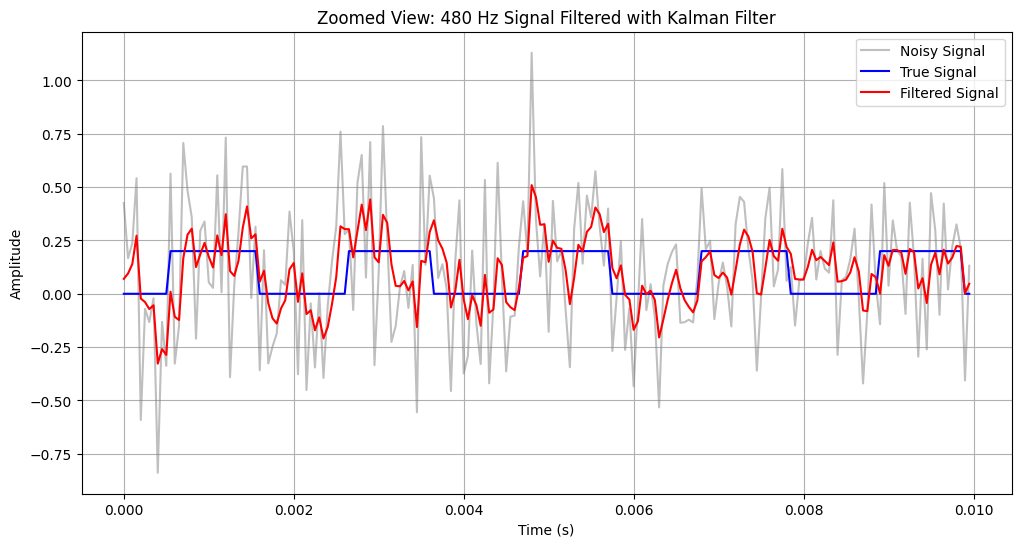

In [10]:
# Initialize Kalman filter
F = np.array([[1]])
H = np.array([[1]])
Q = np.array([[18.679136]])
R = np.array([[100]])
P = np.array([[1]])
x = np.array([[0]])

# Create and apply filter
kf = KalmanFilter(F, H, Q, R, P, x)
filtered_signal = kf.filter(noisy_signal)

# Calculate error metrics
mse, rmse = kf.calculate_error(true_signal, filtered_signal)
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

# Plot results
kf.plot_results(noisy_signal, true_signal, filtered_signal)

# Zoom in to show detail
plt.figure(figsize=(12, 6))
zoom_samples = int(0.01 * sampling_rate)  # Show 10ms
plt.plot(t[:zoom_samples], noisy_signal[:zoom_samples], 'gray', alpha=0.5, label='Noisy Signal')
plt.plot(t[:zoom_samples], true_signal[:zoom_samples], 'b', label='True Signal')
plt.plot(t[:zoom_samples], filtered_signal[:zoom_samples], 'r', label='Filtered Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Zoomed View: 480 Hz Signal Filtered with Kalman Filter')
plt.legend()
plt.grid(True)
plt.show()


# Grid search to find optimal Q and R values

Running grid search for optimal Q, R and P values...


100%|██████████| 100/100 [04:24<00:00,  2.64s/it]

Best parameters found: Q=0.000013, R=0.151991
Best RMSE: 0.104295
Original RMSE: 0.150039
Optimal RMSE: 0.104295
Improvement: 30.49%


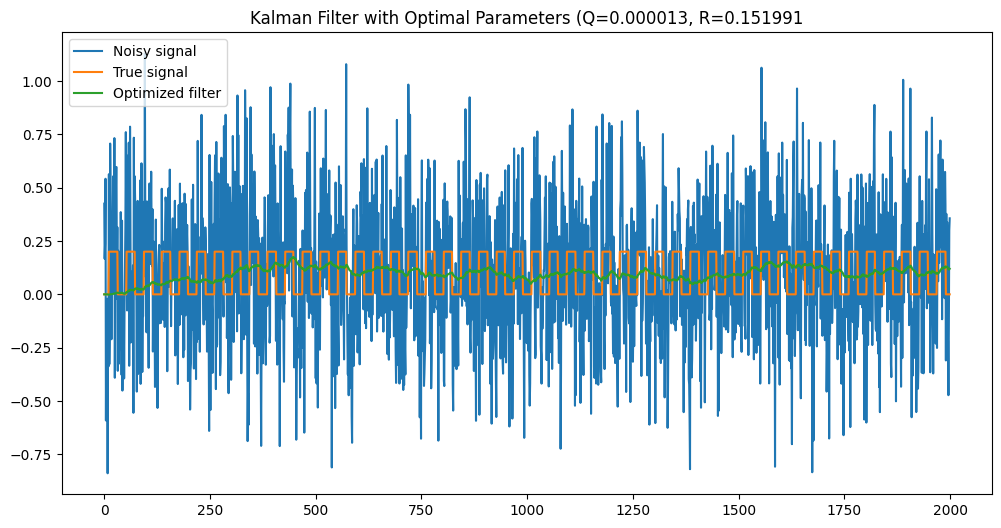

Text(0.5, 1.0, 'RMSE for different Q and R values')

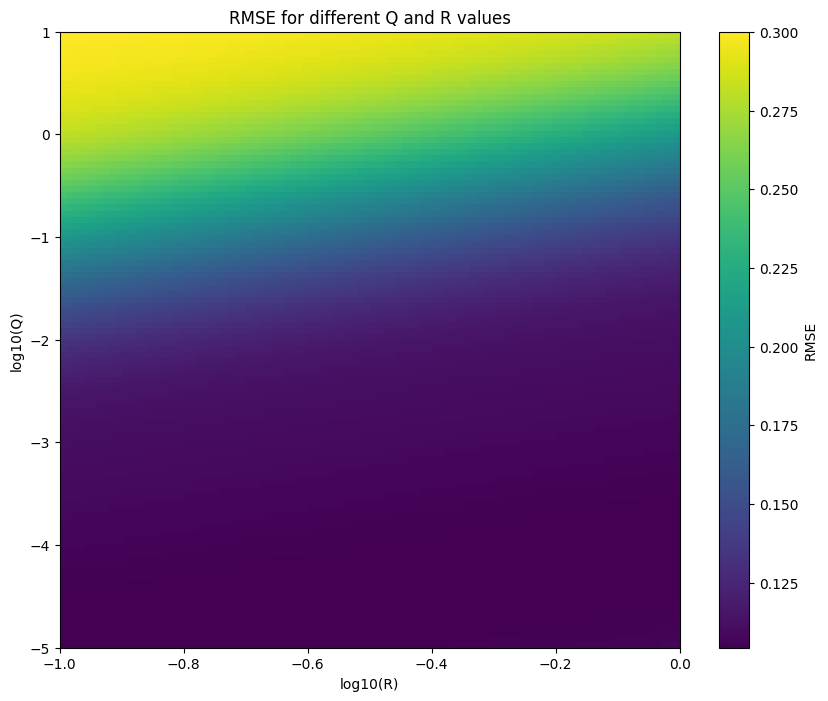

In [11]:


# Define range of values to test
# q_values = np.logspace(-6, 2, 1000)  # 10 values from 0.000001 to 100  23 horas de procesamiento
# r_values = np.logspace(-6, 2, 1000)  # 10 values from 0.000001 to 100

q_values = np.logspace(-5, 1, 100)  # 10 values from 0.001 to 100
r_values = np.logspace(-1, 0, 100)  # 10 values from 0.001 to 1000

#q_values = np.logspace(-3, 2, 50)  # 10 values from 0.001 to 100
#r_values = np.logspace(-3, 3, 50)  # 10 values from 0.001 to 1000
#p_values = np.logspace(-3, 3, 50)   # 10 values from 0.001 to 1000

# Store results
results = []
best_rmse = float('inf')
best_q = None
best_r = None

# Grid search
print("Running grid search for optimal Q, R and P values...")
for q_val in tqdm(q_values):
    for r_val in r_values:
            # Initialize Kalman filter with current parameters
            F = np.array([[1]])
            H = np.array([[1]])
            Q = np.array([[q_val]])
            R = np.array([[r_val]])
            P = np.array([[0]])
            x = np.array([[0]])
            # Initialize Kalman filter with current parameters
            Q = np.array([[q_val]])
            R = np.array([[r_val]])

            # Create and apply filter
            kf = KalmanFilter(F, H, Q, R, P, x)
            filtered = kf.filter(noisy_signal)

            # Calculate error
            _, rmse = kf.calculate_error(true_signal, filtered)
            results.append((q_val, r_val, rmse))

            # Track best parameters
            if rmse < best_rmse:
                best_rmse = rmse
                best_q = q_val
                best_r = r_val

# Print     best parameters
print(f"Best parameters found: Q={best_q:.6f}, R={best_r:.6f}")
print(f"Best RMSE: {best_rmse:.6f}")

# Create filter with optimal parameters
optimal_Q = np.array([[best_q]])
optimal_R = np.array([[best_r]])
P = np.array([[0]])
x = np.array([[0]])
optimal_kf = KalmanFilter(F, H, optimal_Q, optimal_R, P, x)
optimal_filtered = optimal_kf.filter(noisy_signal)

# Calculate improvement over original parameters
original_mse, original_rmse = kf.calculate_error(true_signal, filtered_signal)
optimal_mse, optimal_rmse = kf.calculate_error(true_signal, optimal_filtered)
improvement = ((original_rmse - optimal_rmse) / original_rmse) * 100

print(f"Original RMSE: {original_rmse:.6f}")
print(f"Optimal RMSE: {optimal_rmse:.6f}")
print(f"Improvement: {improvement:.2f}%")

# Plot results with optimal parameters
plt.figure(figsize=(12, 6))
plt.plot(noisy_signal, label='Noisy signal')
plt.plot(true_signal, label='True signal')
plt.plot(optimal_filtered, label='Optimized filter')
plt.legend()
plt.title(f'Kalman Filter with Optimal Parameters (Q={best_q:.6f}, R={best_r:.6f}')
plt.show()

# Create heatmap of RMSE values
rmse_grid = np.zeros((len(q_values), len(r_values)))
for i, q in enumerate(q_values):
    for j, r in enumerate(r_values):
        for result in results:
            if result[0] == q and result[1] == r :
                rmse_grid[i, j] = result[2]
                break

plt.figure(figsize=(10, 8))
plt.imshow(rmse_grid, cmap='viridis', aspect='auto', origin='lower',
            extent=tuple([np.log10(r_values[0]), np.log10(r_values[-1]),
            np.log10(q_values[0]), np.log10(q_values[-1])]))
plt.colorbar(label='RMSE')
plt.xlabel('log10(R)')
plt.ylabel('log10(Q)')
plt.title(f'RMSE for different Q and R values')


# Test Filter on other signals

MSE: 0.010392541203013429
RMSE: 0.10194381395167354


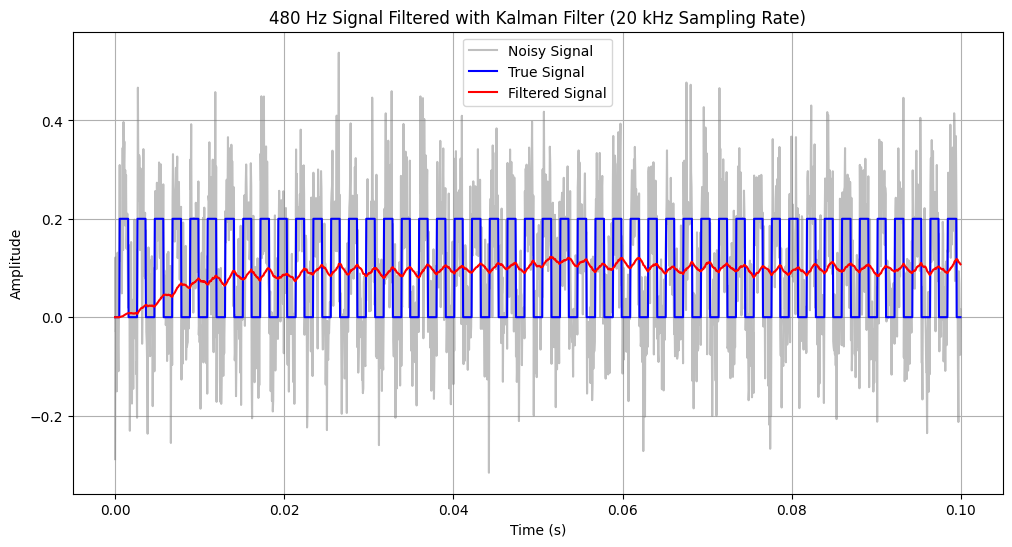

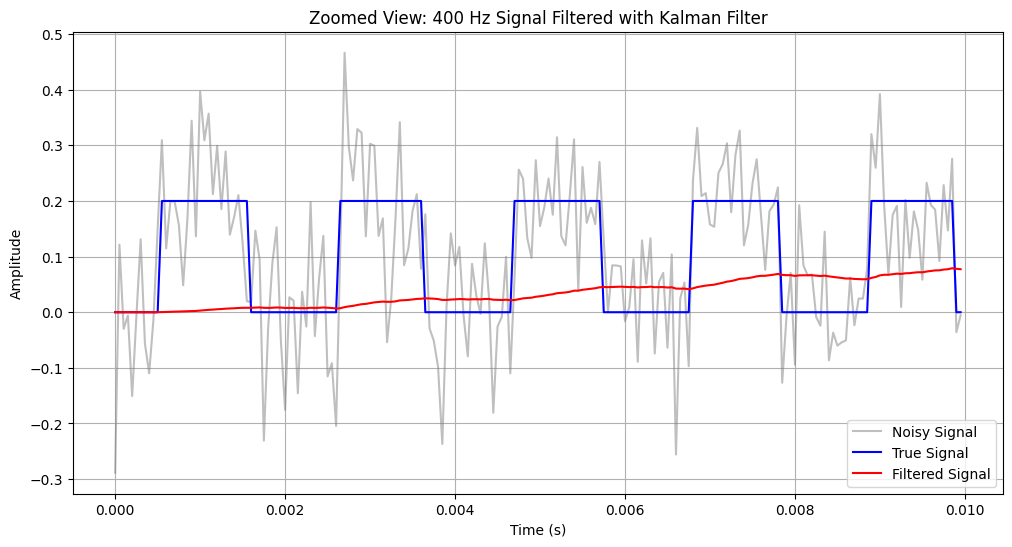

In [12]:
# Add noise to create noisy measurement
noise_std = 0.1
noisy_signal = SigGen.add_noise(true_signal, noise_std)

# Initialize Kalman filter
F = np.array([[1]])
H = np.array([[1]])
Q = np.array([[best_q]])  # Try best values found in grid search
R = np.array([[best_r]])  # Try best values found in grid search
P = np.array([[0]])  #
x = np.array([[0]])

# Create and apply filter
kf = KalmanFilter(F, H, Q, R, P, x)
filtered_signal = kf.filter(noisy_signal)

# Calculate error metrics
mse, rmse = kf.calculate_error(true_signal, filtered_signal)
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(t, noisy_signal, 'gray', alpha=0.5, label='Noisy Signal')
plt.plot(t, true_signal, 'b', label='True Signal')
plt.plot(t, filtered_signal, 'r', label='Filtered Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('480 Hz Signal Filtered with Kalman Filter (20 kHz Sampling Rate)')
plt.legend()
plt.grid(True)

# Zoom in to show detail
plt.figure(figsize=(12, 6))
zoom_samples = int(0.01 * sampling_rate)  # Show 10ms
plt.plot(t[:zoom_samples], noisy_signal[:zoom_samples], 'gray', alpha=0.5, label='Noisy Signal')
plt.plot(t[:zoom_samples], true_signal[:zoom_samples], 'b', label='True Signal')
plt.plot(t[:zoom_samples], filtered_signal[:zoom_samples], 'r', label='Filtered Signal')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Zoomed View: 400 Hz Signal Filtered with Kalman Filter')
plt.legend()
plt.grid(True)
plt.show()